In [103]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from os import walk
import math
from scipy import stats
from matplotlib import rcParams
import dill
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

palette ={"CRC":"grey",'Healthy':'gold'}
allMetaDataDF = pd.read_csv("./Files/Cohorts/Japanese_CRC_Cohort/metaData_fixed.csv").set_index("SampleName")

In [104]:
#def save_obj(obj, name ):
#    with open('./Files/CRCvsHealthy/RFC/AUC_Run/'+ name + '.pkl', 'wb') as f:
#        dill.dump(obj, f, dill.HIGHEST_PROTOCOL)

## Import Dataframes of runs using all species and runs using 17 significant species

In [105]:
feature_allSpecies_df = pd.read_csv("./Files/RFC/allSpecies_FeaturesDF.csv")
feature_allSpecies_df.head()

,Unnamed: 0,Features,Accuracy
0,0,Abiotrophia_defectiva 0.0...,0.710526
1,1,Abiotrophia_defectiva 0.0...,0.763158
2,2,Abiotrophia_defectiva 0.0...,0.736842
3,3,Abiotrophia_defectiva 0.0...,0.763158
4,4,Abiotrophia_defectiva 0.0...,0.723684


In [106]:
feature_17_df = pd.read_csv("./Files/RFC/17ImportantSpecies_FeaturesDF.csv")
feature_17_df.head()

,Unnamed: 0,Features,Accuracy
0,0,Parvimonas_micra 0.132049\nGem...,0.789474
1,1,Parvimonas_micra 0.106762\nGem...,0.763158
2,2,Parvimonas_micra 0.127621\nGem...,0.842105
3,3,Parvimonas_micra 0.086360\nGem...,0.802632
4,4,Parvimonas_micra 0.086442\nGem...,0.815789


In [107]:
feature_allSpecies_df['Feature Group'] = 'All Species'
feature_17_df['Feature Group'] = '17 Species'

In [108]:
featureCombined = pd.concat([feature_allSpecies_df,feature_17_df])

In [109]:
featureCombined.reset_index(inplace=True)
featureCombined.head()

,index,Unnamed: 0,Features,Accuracy,Feature Group
0,0,0,Abiotrophia_defectiva 0.0...,0.710526,All Species
1,1,1,Abiotrophia_defectiva 0.0...,0.763158,All Species
2,2,2,Abiotrophia_defectiva 0.0...,0.736842,All Species
3,3,3,Abiotrophia_defectiva 0.0...,0.763158,All Species
4,4,4,Abiotrophia_defectiva 0.0...,0.723684,All Species


## Plot Results

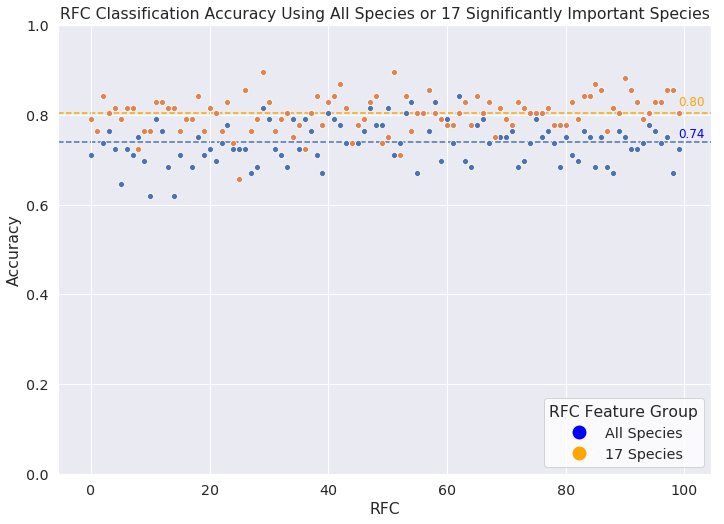

In [110]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
sns.set()
sns.set(font_scale=1.3)
sns.scatterplot(data=feature_allSpecies_df, y='Accuracy', x='Unnamed: 0')
sns.scatterplot(data=feature_17_df, y='Accuracy', x='Unnamed: 0')
plt.ylim((0,1))
plt.xlabel("RFC")
plt.axhline(y=feature_allSpecies_df['Accuracy'].mean(), zorder=0, linestyle='--')
plt.annotate('0.74', xy=(99,.75), color='blue', size=12)

plt.axhline(y=feature_17_df['Accuracy'].mean(), zorder=0, linestyle='--', color='orange')
plt.annotate('0.80', xy=(99,.82), color='orange', size=12)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='white', label='All Species',
                          markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='white', label='17 Species',
                          markerfacecolor='orange', markersize=15)]

# Create the figure
plt.legend(handles=legend_elements, loc=4, facecolor='white', title='RFC Feature Group')
plt.title("RFC Classification Accuracy Using All Species or 17 Significantly Important Species")
plt.show()

## Load Bacterial Relative Abundance DataFrames for all Countries

In [111]:
#Strain Dataframes
CRCStrains = pd.read_csv('./Files/Dataframes/strainDataframes/masterCRC_allStrains.csv').set_index("SampleName")
japaneseStrains = pd.read_csv('./Files/Dataframes/strainDataframes/masterJapanese_allStrains.csv').set_index("SampleName")

CRCStrains_RAc  = CRCStrains.copy()
CRCStrains_RAc['Cohort']='CRC'
japaneseStrains_RAc = japaneseStrains.copy()
japaneseStrains_RAc['Cohort']='Healthy'

In [112]:
#Load all species and 90 union species
BothCohortAllSpecies = pd.read_csv('./Files/Dataframes/allCohorts_allSpecies.csv').set_index("SampleName")
BothCohortSharedSpecies = pd.read_csv('./Files/Dataframes/allCohorts_90Prev_Species.csv').set_index("SampleName")

In [113]:
# Grab the 17 significant species
bothCohortImportantSpecies = BothCohortAllSpecies[['Cohort','Parvimonas_micra','Gemella_morbillorum','Fusobacterium_nucleatum','Peptostreptococcus_stomatis','Dialister_pneumosintes','Peptostreptococcus_anaerobius','Selenomonas_sputigena','Lactobacillus_rogosae','Roseburia_faecis','Prevotella_nigrescens','Ruminococcus_torques','Alloprevotella_tannerae','Prevotella_intermedia','Streptococcus_anginosus','Monoglobus_pectinilyticus','Clostridium_saccharolyticum','Dorea_longicatena']].copy()
bothCohortImportantSpeciesNoCohort = BothCohortAllSpecies[['Parvimonas_micra','Gemella_morbillorum','Fusobacterium_nucleatum','Peptostreptococcus_stomatis','Dialister_pneumosintes','Peptostreptococcus_anaerobius','Selenomonas_sputigena','Lactobacillus_rogosae','Roseburia_faecis','Prevotella_nigrescens','Ruminococcus_torques','Alloprevotella_tannerae','Prevotella_intermedia','Streptococcus_anginosus','Monoglobus_pectinilyticus','Clostridium_saccharolyticum','Dorea_longicatena']].copy()
bothCohortImportantSpecies.head()

,Cohort,Parvimonas_micra,Gemella_morbillorum,Fusobacterium_nucleatum,Peptostreptococcus_stomatis,Dialister_pneumosintes,Peptostreptococcus_anaerobius,Selenomonas_sputigena,Lactobacillus_rogosae,Roseburia_faecis,Prevotella_nigrescens,Ruminococcus_torques,Alloprevotella_tannerae,Prevotella_intermedia,Streptococcus_anginosus,Monoglobus_pectinilyticus,Clostridium_saccharolyticum,Dorea_longicatena
SampleName,,,,,,,,,,,,,,,,,,
DRR127524,Healthy,0.000034,0.000045,0.000000,0.000013,0.0,0.000000,0.0,0.007364,0.002559,0.000012,0.000240,0.000011,0.000120,0.000090,0.000073,0.000057,0.001657
DRR127532,Healthy,0.000034,0.000023,0.000000,0.000100,0.0,0.000000,0.0,0.002204,0.000653,0.000000,0.110252,0.000000,0.000639,0.000000,0.000079,0.000204,0.028816
DRR127535,Healthy,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.004514,0.000586,0.000000,0.001788,0.000000,0.000000,0.000026,0.000045,0.000169,0.001711
DRR127537,Healthy,0.000110,0.000023,0.000036,0.000038,0.0,0.000000,0.0,0.012505,0.001102,0.000000,0.000029,0.000000,0.000000,0.000077,0.000011,0.000000,0.005449
DRR127546,Healthy,0.000025,0.000000,0.000000,0.000015,0.0,0.000013,0.0,0.039368,0.003218,0.000016,0.003961,0.000020,0.000015,0.000011,0.000078,0.000238,0.001938


## CLR Transform

In [114]:
from skbio.stats.composition import clr

def produceCLRDF(df):
    df2 = df.drop(columns=['Cohort']).copy()
    df2.fillna(0.0, inplace=True)
    
    df3 = df2.copy()
    for row in df2.index:
        df3.loc[row] = clr(np.array(df2.loc[row].replace(0.0, 1e-10)))

    df3_wCohort = df3.copy()
    df3_wCohort['Cohort']=df['Cohort'].copy()
    
    return(df3_wCohort)

In [115]:
clr_90_normalized = produceCLRDF(BothCohortSharedSpecies)
clr_90_normalized_noCohort = clr_90_normalized.drop(columns=['Cohort']).copy()

In [116]:
##############################

In [117]:
clr_allSpecies = produceCLRDF(BothCohortAllSpecies)
clr_allSpecies_noCohort = clr_allSpecies.drop(columns=['Cohort']).copy()

In [118]:
############################################

In [119]:
#Grab 17 important species relative abundances transform
clr_17_normalized = produceCLRDF(bothCohortImportantSpecies)
clr_17_normalized_noCohort = clr_17_normalized.drop(columns=['Cohort']).copy()

In [120]:
#Transform all species then grab 17 important species CLR transformed relative abundances
clr_allSpecies_17 = clr_allSpecies[['Cohort','Parvimonas_micra','Gemella_morbillorum','Fusobacterium_nucleatum','Peptostreptococcus_stomatis','Dialister_pneumosintes','Peptostreptococcus_anaerobius','Selenomonas_sputigena','Lactobacillus_rogosae','Roseburia_faecis','Prevotella_nigrescens','Ruminococcus_torques','Alloprevotella_tannerae','Prevotella_intermedia','Streptococcus_anginosus','Monoglobus_pectinilyticus','Clostridium_saccharolyticum','Dorea_longicatena']] .copy()
clr_allSpecies_17_noCohort = clr_allSpecies_17.drop(columns=['Cohort']).copy()

## Random Forest

In [121]:
def buildRandomForest(FeatureDF, LabelDF, groupLabel, testSize, nEstimator):
    X = np.array(FeatureDF)
    y = LabelDF[groupLabel]
    
    # Import train_test_split function
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    
    
        #Import Random Forest Model
    from sklearn.ensemble import RandomForestClassifier

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=nEstimator)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    
    feature_imp = pd.Series(clf.feature_importances_,index=FeatureDF.columns).sort_values(ascending=False)
    
    return (feature_imp, metrics.accuracy_score(y_test, y_pred))

In [122]:
def buildRandomForest2(FeatureDF, LabelDF, groupLabel, testSize, nEstimator):
    X = np.array(FeatureDF)
    y = LabelDF[groupLabel]
    
    # Import train_test_split function
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    
    
        #Import Random Forest Model
    from sklearn.ensemble import RandomForestClassifier

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=nEstimator)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    
    feature_imp = pd.Series(clf.feature_importances_,index=FeatureDF.columns).sort_values(ascending=False)
    
    return (feature_imp, metrics.accuracy_score(y_test, y_pred), clf)

In [123]:
from random import shuffle
randomList = list(clr_allSpecies[clr_allSpecies['Cohort']=='Healthy'].index)

In [124]:
newList =  []
shuffleCount  = 0
while shuffleCount <74:
    shuffle(randomList)
    newList.append(randomList[0])
    randomList.remove(randomList[0])
    shuffleCount+=1

In [125]:
allSampleListRFC = newList+list(clr_allSpecies[clr_allSpecies['Cohort']=='CRC'].index)
print(len(allSampleListRFC))

148


## AUC 

In [126]:
#Code to generate RFC with AUC plot out
def buildRandomForestAUC(FeatureDF, LabelDF, groupLabel, testSize, nEstimator):
    X = np.array(FeatureDF)
    y = LabelDF[groupLabel]
    
    # Import train_test_split function
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    
    
        #Import Random Forest Model
    from sklearn.ensemble import RandomForestClassifier

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=nEstimator)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    
    feature_imp = pd.Series(clf.feature_importances_,index=FeatureDF.columns).sort_values(ascending=False)
    
    svc_disp = plot_roc_curve(clf, X_test, y_test)
    plt.title("Random Forest Classifier ROC AUC")
    plt.show()
    
    return (feature_imp, metrics.accuracy_score(y_test, y_pred), clf, X_test, y_test)

In [127]:
#This code does the same as above but loads in a previous RFC object
def loadRandomForestAUC(clf_in, X_testin, Y_testin):
    svc_disp = plot_roc_curve(clf_in, X_testin, Y_testin)
    plt.title("Random Forest Classifier ROC AUC")
    plt.show()

## Run

In [128]:
#featuressAll, accuracyOutAll, clf_allSpecies, X_testout, Y_testout = buildRandomForestAUC(clr_allSpecies_noCohort, clr_allSpecies, "Cohort", 0.3, 100)

## Export

In [129]:
def save_obj(obj, name ):
    with open('./Files/RFC/AUC_Run/Data/'+ name + '.pkl', 'wb') as f:
        dill.dump(obj, f, dill.HIGHEST_PROTOCOL)

In [130]:
#save_obj(clf_allSpecies, "allSpecies_topModelDictionary")

In [131]:
#np.savetxt('./Files/RFC/AUC_Run/Data/X_test.txt', X_testout)

In [132]:
#Y_testout.to_csv("./Files/RFC/AUC_Run/Data/y_test.csv")

## Reload

In [133]:
import pickle
#This is the RFC with the AUC of 0.83
with open('./Files/RFC/AUC_Run/Data/allSpecies_topModelDictionary.pkl', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [134]:
X_testSaved = np.loadtxt('./Files/RFC/AUC_Run/Data/X_test.txt', dtype=float)

In [135]:
Y_testSaved = pd.read_csv("./Files/RFC/AUC_Run/Data/y_test.csv").set_index("SampleName")
Y_testSaved.head()

,Unnamed: 1
SampleName,
DRR171819,CRC
DRR171487,Healthy
DRR171662,Healthy
DRR171608,Healthy
DRR127776,Healthy


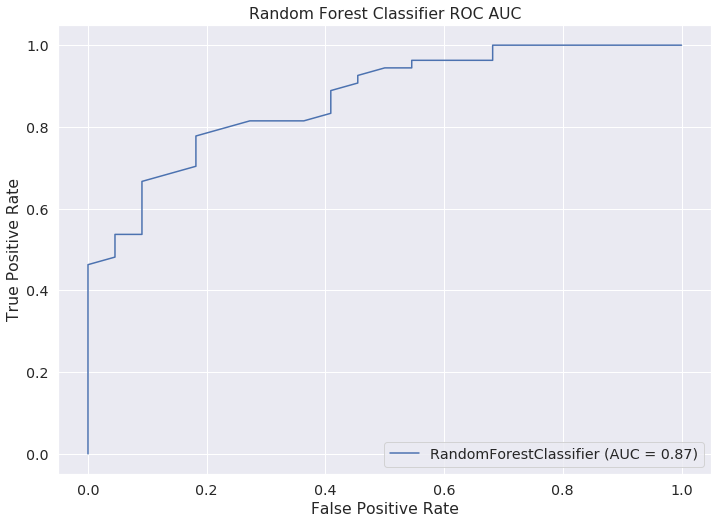

In [136]:
#FeatureDF, LabelDF, groupLabel, testSize, clf_in, X_test, Y_test
loadRandomForestAUC(content, X_testSaved,Y_testSaved)

In [137]:
#featuressAll.to_csv("./Files/RFC/AUC_Run/Data/allSpeciesAUCFeaturesDF.csv")
aucRun =  pd.read_csv("./Files/RFC/AUC_Run/Data/allSpeciesAUCFeaturesDF.csv").set_index("Species")
aucRun.head()

,RFC_Importance
Species,
Parvimonas_micra,0.026121
Peptostreptococcus_stomatis,0.022817
Fusobacterium_nucleatum,0.012520
Gemella_morbillorum,0.012511
Dialister_pneumosintes,0.007864


## Multi-Forest

In [138]:
def createRandomColumn(df):
    import random
    from random import shuffle

    df_random = df.copy()
    random_CLRS = []
    
    for sample in df.index:
        randomNumber = random.randrange(len(df.columns))
        temp = list(df.loc[sample])
        shuffle(temp)
        random_CLRS.append(temp[randomNumber])
        
    df_random['Random'] = random_CLRS
    
    return(df_random)

In [139]:
#Creates random feature before RFC
clr_allSpecies_random = createRandomColumn(clr_allSpecies_noCohort)

In [140]:
def buildMultiRandomForest(FeatureDF, LabelDF, groupLabel, testSize, nEstimator, repeats):
    i = 0
    tempDict = {"Features":[], "Accuracy":[]}
    topModel = {}
    while i < repeats:
        X = np.array(FeatureDF)
        y = LabelDF[groupLabel]

        # Import train_test_split function
        from sklearn.model_selection import train_test_split

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)


            #Import Random Forest Model
        from sklearn.ensemble import RandomForestClassifier

        #Create a Gaussian Classifier
        clf=RandomForestClassifier(n_estimators=nEstimator)

        #Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train,y_train)

        y_pred=clf.predict(X_test)

        #Import scikit-learn metrics module for accuracy calculation
        from sklearn import metrics
        feature_imp = pd.Series(clf.feature_importances_,index=FeatureDF.columns)
        tempDict['Features'].append(feature_imp)
        tempDict['Accuracy'].append(metrics.accuracy_score(y_test, y_pred))
        
        topModel[i] = {clf:metrics.accuracy_score(y_test, y_pred)}
        i+=1
        
    tempDF = pd.DataFrame(data=tempDict)
    return (tempDF, topModel)

In [141]:
def save_obj(obj, name ):
    with open('./Files/RFC/Models/'+ name + '.pkl', 'wb') as f:
        dill.dump(obj, f, dill.HIGHEST_PROTOCOL)

In [142]:
#ALL SPECIES
#feature_allSpecies_df, topModels = buildMultiRandomForest(clr_allSpecies_random, clr_allSpecies, "Cohort", 0.3, 100,100)

In [143]:
#feature_allSpecies_df.to_csv("./Files/RFC/allSpecies_FeaturesDF.csv")

In [144]:
#save_obj(topModels, "allSpecies_topModelDictionary")

In [145]:
###############################################################################################3

In [146]:
#ALL SPECIES
#feature_allSpecies_df, topModels = buildMultiRandomForest(clr_allSpecies_17_noCohort, clr_allSpecies_17, "Cohort", 0.3, 100, 100)

In [147]:
#feature_allSpecies_df.to_csv("./Files/RFC/17ImportantSpecies_FeaturesDF.csv")

## Reload Multi

In [148]:
import pickle
with open('./Files/RFC/Models/MultiRuns/allSpecies_topModelDictionary.pkl', 'rb') as pickle_file:
    content2 = pickle.load(pickle_file)

/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. Th

/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. Th

/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. Th

/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mark/anaconda3/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.2. Th

## Build Feature DataFrame, Test for Statistical Significance against Random Feature

In [149]:
feature_allSpecies_df = pd.read_csv("./Files/RFC/allSpecies_FeaturesDF.csv")
feature_allSpecies_df.head()

,Unnamed: 0,Features,Accuracy
0,0,Abiotrophia_defectiva 0.0...,0.710526
1,1,Abiotrophia_defectiva 0.0...,0.763158
2,2,Abiotrophia_defectiva 0.0...,0.736842
3,3,Abiotrophia_defectiva 0.0...,0.763158
4,4,Abiotrophia_defectiva 0.0...,0.723684


In [150]:
def buildFeatureMatrix(featureDF,randomDF, rangeNum):
    
    FeatureMatrix = pd.DataFrame(index=range(rangeNum), columns=randomDF.columns)
    
    FeatureMatrix.fillna(0.0, inplace=True)
    
    tempHolder = []
    for x,y in content2.items():
        for rfc in (y):
            tempHolder.append(list(rfc.feature_importances_))

            
    for run in list(featureDF['Unnamed: 0']):
        FeatureMatrix.loc[run] = tempHolder[int(run)]
        
    return(FeatureMatrix)

In [151]:
# Test for statistical significance Mann-Whitney U Test
from statsmodels.stats.multitest import multipletests
import scipy
from scipy import stats
import os
import statistics
import statsmodels
import statsmodels.api as sm 
import random

def runMann_DA(df, alpha, correction):
    
    dfstat={'Species':[],'Species_Importance_Median':[], "Species_Import_Dist":[], "Random_Importance_Median":[], "Random_Import_Dist":[], 'Test':[],'Test_Statistic':[],'P_Value':[]}
    
    df2 = df.drop(columns=["Random"]).copy()
    
    for species in list(df2.columns):
        dfstat['Species'].append(species)

        SpeciesImportance = list(reversed(sorted(list(df2[species]),key=float)))
        randomImportance = list(reversed(sorted(list(df["Random"]),key=float)))

        #Check Data Distribution for Normalicy: based on D’Agostino and Pearson’s 
        
        nt1, np1 = stats.normaltest(SpeciesImportance)
        nt2, np2 = stats.normaltest(randomImportance)

        if (np1 < alpha):
                dfstat["Species_Import_Dist"].append('Not Normally Distributed')
        else:
                dfstat["Species_Import_Dist"].append('Normally Distributed')

        if (np2 < alpha):
                dfstat["Random_Import_Dist"].append('Not Normally Distributed')
        else:
                dfstat["Random_Import_Dist"].append('Normally Distributed')


        (test_statistic, p_value) = stats.mannwhitneyu(SpeciesImportance,randomImportance, alternative="greater") 

        dfstat["Species_Importance_Median"].append(statistics.median(SpeciesImportance))
        dfstat["Random_Importance_Median"].append(statistics.median(randomImportance))
        dfstat['Test'].append('Mann-Whitney U Test')
        dfstat['Test_Statistic'].append(test_statistic)
        dfstat['P_Value'].append(p_value)

    # Perform multiple testing correction
    dfstat2 = pd.DataFrame(data=dfstat)
    dfstat3 = dfstat2.copy()
    FDRcorrectionList= multipletests(dfstat2['P_Value'], alpha=alpha, method=correction, is_sorted=False, returnsorted=False)
    dfstat3['Correction_Performed'] = correction
    dfstat3['Corrected_Pvalue'] = list(FDRcorrectionList[1])
    dfstat3['Reject'] = list(FDRcorrectionList[0])
    return (dfstat3)

In [152]:
###########################################################################################

In [153]:
allSpecies_Importance = buildFeatureMatrix(feature_allSpecies_df, clr_allSpecies_random, 100)

In [154]:
significantImportanceFeatures_allSpecies = runMann_DA(allSpecies_Importance, alpha=0.05, correction="fdr_bh").set_index("Species")

## View Top Species above StatSig

In [155]:
TopSigs_AllSpecies = significantImportanceFeatures_allSpecies[significantImportanceFeatures_allSpecies['Reject']==True].sort_values(by=['Species_Importance_Median'],ascending=False)
TopSigs_AllSpecies

,Species_Importance_Median,Species_Import_Dist,Random_Importance_Median,Random_Import_Dist,Test,Test_Statistic,P_Value,Correction_Performed,Corrected_Pvalue,Reject
Species,,,,,,,,,,
Parvimonas_micra,0.017749,Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9984.0,2.070232e-34,fdr_bh,1.358420e-31,True
Gemella_morbillorum,0.017497,Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9994.0,1.533974e-34,fdr_bh,1.358420e-31,True
Fusobacterium_nucleatum,0.016824,Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9962.0,3.995352e-34,fdr_bh,1.358420e-31,True
Peptostreptococcus_stomatis,0.016638,Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9965.0,3.653354e-34,fdr_bh,1.358420e-31,True
Dialister_pneumosintes,0.007885,Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9274.0,7.985735e-26,fdr_bh,2.172120e-23,True
Peptostreptococcus_anaerobius,0.005926,Not Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,9186.5,7.425501e-25,fdr_bh,1.683114e-22,True
Selenomonas_sputigena,0.004498,Not Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,7883.0,9.402588e-13,fdr_bh,1.598440e-10,True
Lactobacillus_rogosae,0.004339,Not Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,7687.5,2.594870e-11,fdr_bh,3.529024e-09,True
Roseburia_faecis,0.004303,Not Normally Distributed,0.001737,Not Normally Distributed,Mann-Whitney U Test,8145.0,7.755951e-15,fdr_bh,1.506870e-12,True


## Plot StatSig Species

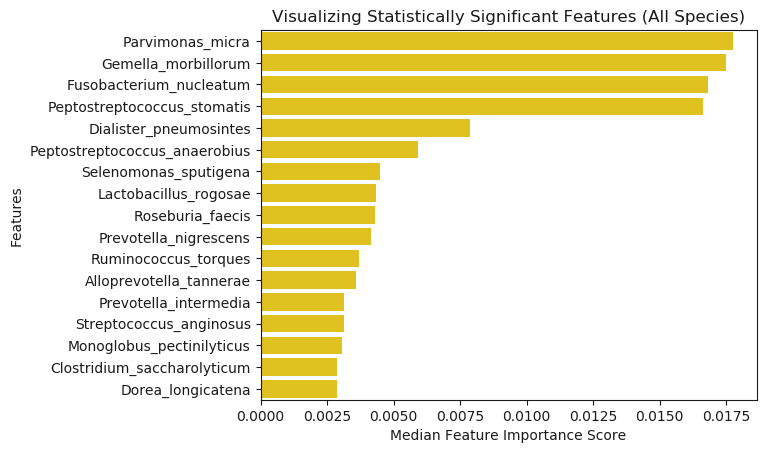

In [156]:
# Creating a bar plot
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.barplot(x=TopSigs_AllSpecies.Species_Importance_Median, y=TopSigs_AllSpecies.index, color='gold')
# Add labels to your graph
plt.xlabel('Median Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Statistically Significant Features (All Species)")
#plt.legend()
#plt.savefig("topFeatures_ImportanceScores_allSpecies.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Look at abundance difference

In [157]:
# Test for statistical significance Mann-Whitney U Test
from statsmodels.stats.multitest import multipletests
import scipy
from scipy import stats
import os
import statistics
import statsmodels
import statsmodels.api as sm 
import random

def runMann_DA(df1, df2, alpha, correction):
    
    dfstat={'Species':[], "Healthy_Median":[], "Healthy_Distribution":[], "CRC_Median":[], "CRC_Distribution":[],'Test':[],'Test_Statistic':[],'P_Value':[]}
    
    dfHealthy = df1.copy()
    dfCRC = df2.copy()
    
    MTC_Value = float(alpha)/len(df2.columns)
    
    for species in list(dfHealthy.columns):
        dfstat['Species'].append(species)

        healthySpecies = list(reversed(sorted(list(dfHealthy[species]),key=float)))
        crcSpecies = list(reversed(sorted(list(dfCRC[species]),key=float)))

        #Check Data Distribution for Normalicy: based on D’Agostino and Pearson’s 
        try:
            nt1, np1 = stats.normaltest(healthySpecies)
            nt2, np2 = stats.normaltest(crcSpecies)

            if (np1 < alpha):
                    dfstat["Healthy_Distribution"].append('Not Normally Distributed')
            else:
                    dfstat["Healthy_Distribution"].append('Normally Distributed')

            if (np2 < alpha):
                    dfstat["CRC_Distribution"].append('Not Normally Distributed')
            else:
                    dfstat["CRC_Distribution"].append('Normally Distributed')


            (test_statistic, p_value) = stats.mannwhitneyu(healthySpecies,crcSpecies, alternative="two-sided") 

            dfstat["Healthy_Median"].append(statistics.median(healthySpecies))
            dfstat["CRC_Median"].append(statistics.median(crcSpecies))
            dfstat['Test'].append('Mann-Whitney U Test')
            dfstat['Test_Statistic'].append(test_statistic)
            dfstat['P_Value'].append(p_value)
        except:
            dfstat["Healthy_Distribution"].append('Not Enough Samples')
            dfstat["CRC_Distribution"].append('Not Enough Samples')
            dfstat["Healthy_Median"].append('Not Enough Samples')
            dfstat["CRC_Median"].append('Not Enough Samples')
            dfstat['Test'].append('Not Enough Samples')
            dfstat['Test_Statistic'].append('Not Enough Samples')
            dfstat['P_Value'].append('Not Enough Samples')

    # Perform multiple testing correction
    dfstat2 = pd.DataFrame(data=dfstat)
    dfstat3 = dfstat2.copy()
    FDRcorrectionList= multipletests(dfstat2['P_Value'], alpha=alpha, method=correction, is_sorted=False, returnsorted=False)
    dfstat3['Correction_Performed'] = correction
    dfstat3['Corrected_Pvalue'] = list(FDRcorrectionList[1])
    dfstat3['Reject'] = list(FDRcorrectionList[0])
    dfstat4 = dfstat3[dfstat3['Reject']==True].copy()
    return (dfstat4)

In [158]:
da_crc = clr_allSpecies[clr_allSpecies['Cohort']=='CRC'].drop(columns=['Cohort']).copy()
da_healthy = clr_allSpecies[clr_allSpecies['Cohort']=='Healthy'].drop(columns=['Cohort']).copy()

In [159]:
daSpecies = runMann_DA(da_healthy,da_crc, 0.05, 'fdr_bh')
daSpecies2 = daSpecies.set_index("Species").sort_values(by=['Corrected_Pvalue']).copy()

In [160]:
#daSpecies2.to_csv("./Files/DifferentialAbundance/DifferentialAbundance/Differential_Abundance_AllSpecies.csv")

In [161]:
daSpecies2 = pd.read_csv("./Files/DifferentialAbundance/Differential_Abundance_AllSpecies.csv").set_index("Species")
daSpecies2.head()

,Healthy_Median,Healthy_Distribution,CRC_Median,CRC_Distribution,Test,Test_Statistic,P_Value,Correction_Performed,Corrected_Pvalue,Reject
Species,,,,,,,,,,
Parvimonas_micra,2.991341,Normally Distributed,10.527700,Not Normally Distributed,Mann-Whitney U Test,2888.0,2.277013e-12,fdr_bh,3.096737e-09,True
Peptostreptococcus_stomatis,-2.576004,Normally Distributed,10.290050,Not Normally Distributed,Mann-Whitney U Test,3145.0,6.634730e-11,fdr_bh,4.511617e-08,True
Gemella_morbillorum,-2.686775,Normally Distributed,9.731965,Not Normally Distributed,Mann-Whitney U Test,3178.0,1.005849e-10,fdr_bh,4.559847e-08,True
Fusobacterium_nucleatum,-3.113394,Not Normally Distributed,9.405304,Not Normally Distributed,Mann-Whitney U Test,3465.0,3.190989e-09,fdr_bh,1.084936e-06,True
Acetanaerobacterium_elongatum,-3.218894,Not Normally Distributed,-3.569749,Normally Distributed,Mann-Whitney U Test,8614.0,1.193865e-04,fdr_bh,1.136555e-03,True


## Make a list of RFC Important species that are also found in Differential relative abundance

In [162]:
noSpecies = []
yesSpecies = []
for species in TopSigs_AllSpecies.index:
    if species in daSpecies2.index:
        yesSpecies.append(species.strip())
    else:
        noSpecies.append(species)
yesSpecies

['Parvimonas_micra',
 'Gemella_morbillorum',
 'Fusobacterium_nucleatum',
 'Peptostreptococcus_stomatis',
 'Dialister_pneumosintes',
 'Peptostreptococcus_anaerobius',
 'Lactobacillus_rogosae',
 'Roseburia_faecis',
 'Ruminococcus_torques',
 'Streptococcus_anginosus',
 'Monoglobus_pectinilyticus',
 'Clostridium_saccharolyticum']

In [163]:
trimYes = yesSpecies.copy()
for species in yesSpecies:
    if species in BothCohortSharedSpecies.columns:
        trimYes.remove(species.strip())

In [164]:
cleanNames = [k.replace("_"," ") for k in yesSpecies]

In [165]:
#Load all species and 90 union species
BothCohortAllSpecies = pd.read_csv('./Files/Dataframes/allCohorts_allSpecies.csv').set_index("SampleName")
BothCohortSharedSpecies = pd.read_csv('./Files/Dataframes/allCohorts_90Prev_Species.csv').set_index("SampleName")

In [166]:
GoodSpeciesList = list(set(list(BothCohortSharedSpecies.columns) + list(yesSpecies)))

In [167]:
newNetworkSpeciesDF = BothCohortAllSpecies[GoodSpeciesList].copy()
newNetworkSpeciesDF.to_csv("./Files/GGM/RFC_DA_Run/RFC_DA_SpeciesAbundance.csv")

In [168]:
clr_newNetworkSpeciesDF= produceCLRDF(newNetworkSpeciesDF)
clr_newNetworkSpeciesDF[clr_newNetworkSpeciesDF['Cohort']=='CRC'].drop(columns=['Cohort']).to_csv("./Files/GGM/RFC_DA_Run/CRC_CLR_RFC_DA_SpeciesAbundance.csv")
clr_newNetworkSpeciesDF[clr_newNetworkSpeciesDF['Cohort']=='Healthy'].drop(columns=['Cohort']).to_csv("./Files/GGM/RFC_DA_Run/Healthy_CLR_RFC_DA_SpeciesAbundance.csv")

## View Abundance and Prevalence

In [169]:
def pullAbundances(df, featureList):
    df2 = df[featureList].copy()
    
    tempDict = {"SampleName":[], "Species":[], "Abundance":[], "Cohort":[]}
    
    for i in df2.index:
        for species in df2.columns:
            tempDict['SampleName'].append(i)
            tempDict['Species'].append(species)
            tempDict['Abundance'].append(df2.at[i,species])
            tempDict['Cohort'].append(df.at[i,'Cohort'])
            
    tempDF = pd.DataFrame(data=tempDict).set_index("SampleName").dropna()
    return (tempDF)

In [170]:
aPrevDf = BothCohortAllSpecies.replace(0.0,np.nan).copy()

In [171]:
allPrevalenceAbundance = pd.read_csv("./Files/Prevalence/allCohorts_speciesPrevalenceAbundance.csv").set_index("Bacterial_Species")
allPrevalenceAbundance.head()

,Prevalence,Mean_Relative_Abundance,Cohort
Bacterial_Species,,,
Abiotrophia_defectiva,0.359551,0.000071,Healthy
Absiella_dolichum,0.994382,0.000543,Healthy
Acetanaerobacterium_elongatum,0.016854,0.000014,Healthy
Acetitomaculum_ruminis,0.112360,0.000018,Healthy
Acetivibrio_ethanolgignens,0.988764,0.000264,Healthy


In [172]:
for species in allPrevalenceAbundance.index:
    try:
        allPrevalenceAbundance.rename(index={species:species.replace("_"," ")}, inplace=True)
    except:
        continue

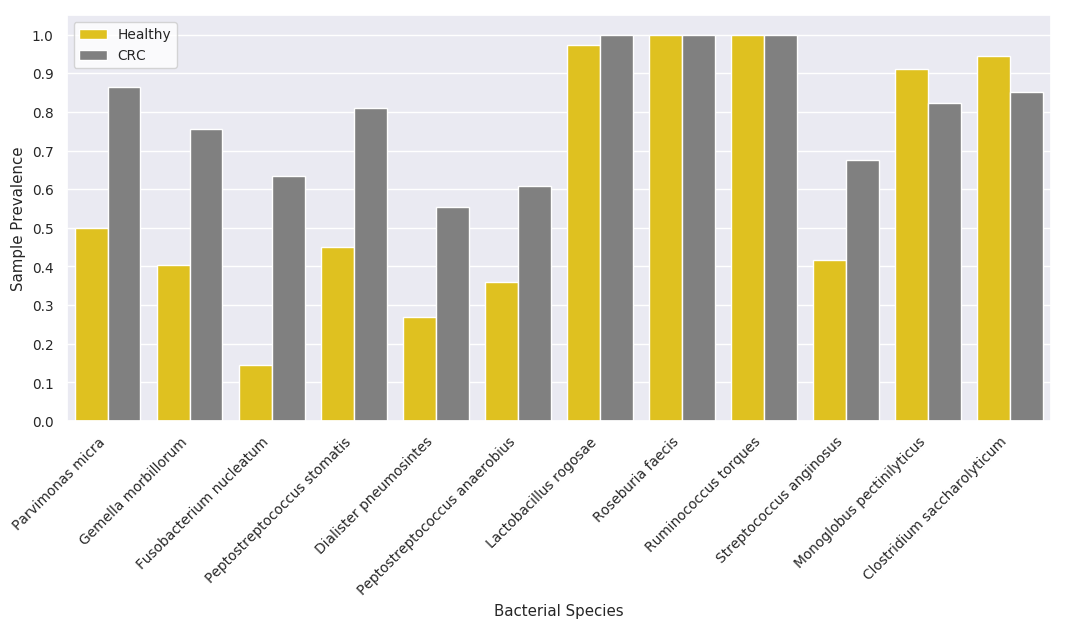

In [173]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12.7,5.27
sns.set()
palette ={'Healthy':'gold', 'CRC':'grey'}

sns.set(font_scale=.9)
ax = sns.barplot(x=allPrevalenceAbundance.loc[cleanNames].index, y="Prevalence", hue="Cohort", data=allPrevalenceAbundance.loc[cleanNames], palette=palette)
#ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0)
ax.legend(facecolor='white')
ax.set(yticks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
#plt.xticks(rotation='vertical')
plt.ylabel('Sample Prevalence')
plt.xlabel('Bacterial Species')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')
plt.show()

In [174]:
abundanceFeaturesDF = pullAbundances(aPrevDf,yesSpecies)
abundanceFeaturesDF.head()

,Species,Abundance,Cohort
SampleName,,,
DRR127524,Parvimonas_micra,0.000034,Healthy
DRR127524,Gemella_morbillorum,0.000045,Healthy
DRR127524,Peptostreptococcus_stomatis,0.000013,Healthy
DRR127524,Lactobacillus_rogosae,0.007364,Healthy
DRR127524,Roseburia_faecis,0.002559,Healthy


In [175]:
tempList = [k.replace("_", " ") for k in abundanceFeaturesDF['Species']]
abundanceFeaturesDF['Clean_SpeciesName'] = tempList
abundanceFeaturesDF.head()

,Species,Abundance,Cohort,Clean_SpeciesName
SampleName,,,,
DRR127524,Parvimonas_micra,0.000034,Healthy,Parvimonas micra
DRR127524,Gemella_morbillorum,0.000045,Healthy,Gemella morbillorum
DRR127524,Peptostreptococcus_stomatis,0.000013,Healthy,Peptostreptococcus stomatis
DRR127524,Lactobacillus_rogosae,0.007364,Healthy,Lactobacillus rogosae
DRR127524,Roseburia_faecis,0.002559,Healthy,Roseburia faecis


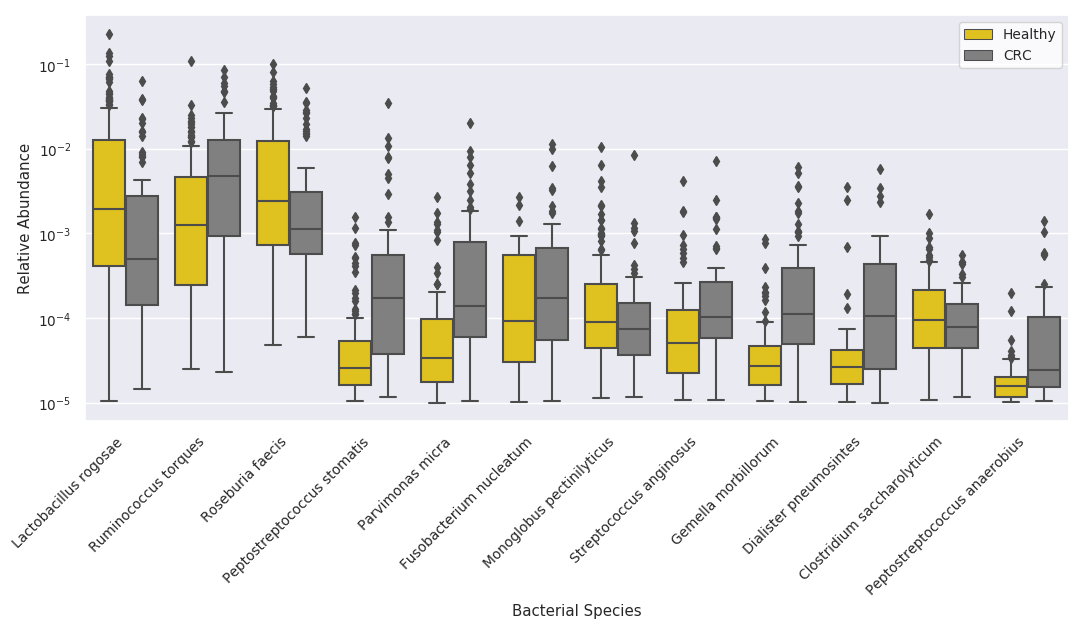

In [176]:
ax = sns.boxplot(x="Clean_SpeciesName", y="Abundance", hue="Cohort", data=abundanceFeaturesDF.sort_values(by=['Abundance'],ascending=False), palette=palette)
ax.set_yscale("log")
#plt.xticks(rotation='vertical')
plt.ylabel('Relative Abundance')
plt.xlabel('Bacterial Species')
ax.legend(facecolor='white')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')
plt.show()